## Body Crop algorithm deployment

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
from inference import SmartBodyCrop
from PIL import Image
import numpy as np

In [2]:
#model_url = "https://s3.amazonaws.com/rt-dev-public-models/openpose/2dw1oz9l9hi9avg/optimized_openpose.pb"
model_url = "models/optimized_openpose.pb"
inf = SmartBodyCrop(model_url = model_url)

## Download the deep learning (open pose) model

In [4]:
#!mkdir -p models
#!curl -L https://www.dropbox.com/s/2dw1oz9l9hi9avg/optimized_openpose.pb -o models/optimized_openpose.pb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  1204    0  1204    0     0    525      0 --:--:--  0:00:02 --:--:--     0
100  199M  100  199M    0     0  2809k      0  0:01:12  0:01:12 --:--:-- 1076k2k


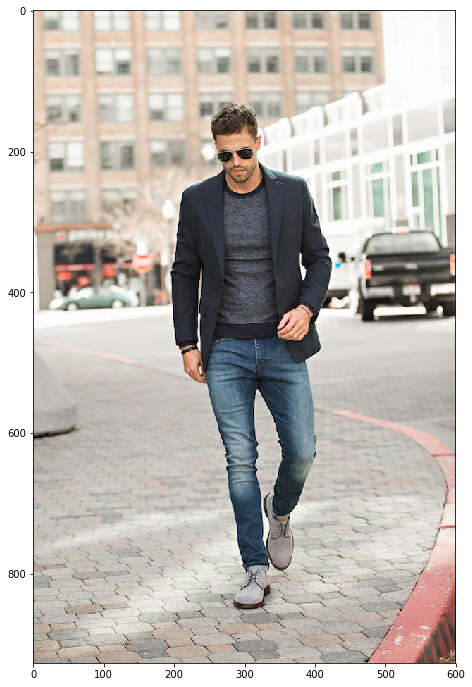

In [5]:
image = Image.open('fashion-men-11.jpg')
image = np.asarray(image)
plt.figure(figsize = (24,12))
plt.imshow(image)
plt.show()

## How algorithm sees the body

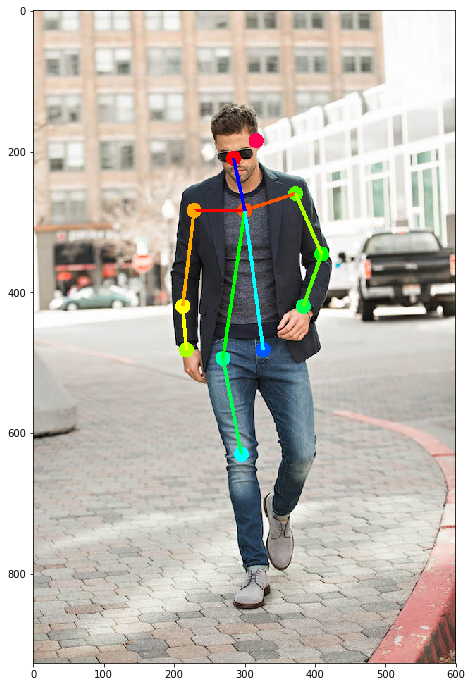

In [6]:
x = inf.detect_parts('fashion-men-11.jpg')
plt.figure(figsize=(24,12))
plt.imshow(x)
plt.show()

## Bodycrop based on detected body parts

image loaded in:      0.0977
Loading the model...
model downloaded in :    61.9212
model imported in :    62.7373
tf session executed in:     74.3063
pose estimated in:      0.0104
image cropped in:      0.0287


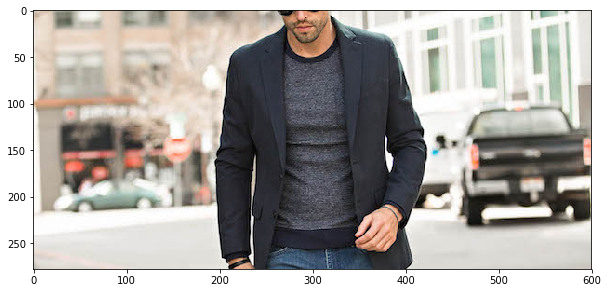

In [5]:
x = inf.infer('fashion-men-11.jpg','Nose','Hips')
plt.figure(figsize = (10,6))
plt.imshow(x)
plt.show()

## Test with another image too

image loaded in:      0.0415
tf session executed in:      6.3613
pose estimated in:      0.0048
image cropped in:      0.0230


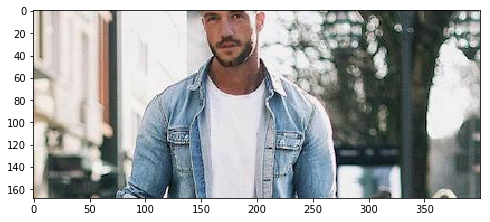

In [6]:
x = inf.infer('fashion-men-1.jpg','Eyes','Elbows')
plt.figure(figsize = (8,4))
plt.imshow(x)
plt.show()

## Test with a remote image 

image downloaded in :     0.4919
image loaded in:      0.5037
tf session executed in:      3.5507
pose estimated in:      0.0041
image cropped in:      0.0040


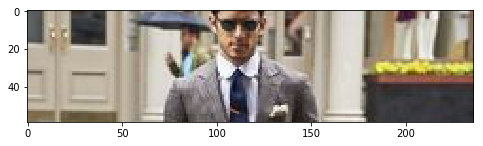

In [7]:
x = inf.infer('https://i.pinimg.com/236x/17/1c/a6/171ca6b06111529aa6f10b1f4e418339--style-men-my-style.jpg','Eyes','Elbows')
plt.figure(figsize = (8,4))
plt.imshow(x)
plt.show()

# Deploy the algorithm as a function

### 1. Write the function

In [11]:
%%writefile smart_body_crop_5.py

from inference import SmartBodyCrop

def action_handler(args):
    model_url = args.get('model_url')
    body_crop = SmartBodyCrop(model_url = model_url)
    print(SmartBodyCrop.initialized)
    crop = body_crop.infer(args.get('image_url'), 
                    args.get('from-upper'), 
                    args.get('to-lower'))
    return crop.shape
    

Writing smart_body_crop_5.py


### Test the function locally

In [12]:
%%time
from smart_body_crop_5 import action_handler
action_response = action_handler({ 
    'model_url': model_url,
    'image_url': 'https://i.pinimg.com/236x/17/1c/a6/171ca6b06111529aa6f10b1f4e418339--style-men-my-style.jpg',
    'from-upper': 'Eyes',
    'to-lower': 'Elbows'})

print(action_response)

True
image downloaded in :     0.6307
image loaded in:      0.6421
tf session executed in:      3.5685
pose estimated in:      0.0043
[defaultdict(<function human_conns_to_human_parts.<locals>.<lambda> at 0x7f41c430d2f0>, {0: (0, (0.4444444444444444, 0.2), 0.66979593), 1: (1, (0.4444444444444444, 0.26666666666666666), 0.7937524), 2: (2, (0.35555555555555557, 0.26666666666666666), 0.6632499), 3: (3, (0.28888888888888886, 0.36666666666666664), 0.637534), 4: (4, (0.28888888888888886, 0.5), 0.8321637), 5: (5, (0.5333333333333333, 0.26666666666666666), 0.7507968), 6: (6, (0.6, 0.3), 0.553517), 7: (7, (0.6444444444444445, 0.4666666666666667), 0.6993296), 8: (8, (0.4, 0.5), 0.6897522), 9: (9, (0.4222222222222222, 0.6666666666666666), 0.8328757), 10: (10, (0.4666666666666667, 0.8333333333333334), 0.84876096), 11: (11, (0.5111111111111111, 0.4666666666666667), 0.6087319), 12: (12, (0.5333333333333333, 0.6666666666666666), 0.6962844), 13: (13, (0.5555555555555556, 0.8666666666666667), 0.7663175)

### 2. Configure a FaaS Provider to deploy the function

### 3. Deploy the function